# Model Deployment on Vertex AI with Tensorflow

Contributors: michaelmenzel@google.com

## Local Model Training

In [14]:
from google.cloud import storage

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import joblib
import os

In [15]:
iris_data, iris_info = tfds.load('iris', split='train', with_info=True)
iris_info

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='/home/jupyter/tensorflow_datasets/iris/2.0.0',
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_exampl

In [16]:
iris_ds = iris_data.map(lambda x: (x['features'], tf.one_hot(x['label'], iris_info.features['label'].num_classes))).batch(5)
iris_train = iris_ds.skip(15)
iris_test = iris_ds.take(15)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


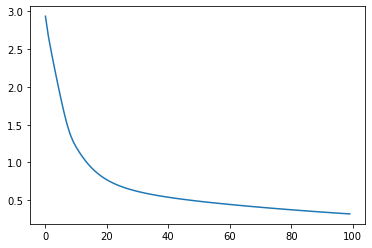

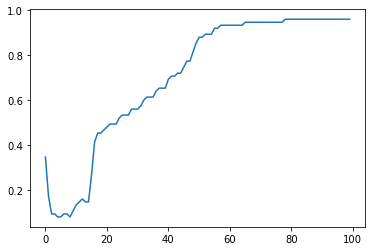

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, input_shape=iris_info.features['features'].shape),
    tf.keras.layers.Dense(iris_info.features['label'].num_classes, activation='softmax')  
])
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(iris_train, epochs=100, verbose=0)

df_hist = pd.DataFrame(history.history)
df_hist['loss'].plot()
plt.show()
df_hist['categorical_accuracy'].plot()
plt.show()

In [18]:
loss, accuracy, precision, recall = model.evaluate(iris_test, verbose=2)

15/15 - 0s - loss: 0.2787 - categorical_accuracy: 0.9867 - precision_2: 0.9867 - recall_2: 0.9867


In [19]:
model_file = 'gs://sandbox-michael-menzel-model/tf-iris-classifier/model.tfmodel'

model.save(model_file)

INFO:tensorflow:Assets written to: gs://sandbox-michael-menzel-model/tf-iris-classifier/model.tfmodel/assets


INFO:tensorflow:Assets written to: gs://sandbox-michael-menzel-model/tf-iris-classifier/model.tfmodel/assets


## Model Deployment

In [20]:
!pip install -q --user --no-warn-conflicts google-cloud-aiplatform

In [21]:
from google.cloud import aiplatform

aiplatform.init(location='europe-west4')

In [22]:
vertex_ai_model = aiplatform.Model.upload(
    display_name='tf-iris-classifier',
    artifact_uri=model_file,
    serving_container_image_uri='europe-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest',
)
 
vertex_ai_model.wait()

In [23]:
vertex_ai_endpoint = vertex_ai_model.deploy(
    deployed_model_display_name='tf-iris-classifier-model',
    traffic_split={"0": 100},
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
)

In [24]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

for X_test, y_test in iris_test.as_numpy_iterator():
    vertex_ai_predicted = vertex_ai_endpoint.predict(X_test.tolist())
    print(f'categorical accuracy: {tf.keras.metrics.categorical_accuracy(y_test, vertex_ai_predicted.predictions)}')
    precision.update_state(y_test, vertex_ai_predicted.predictions)
    recall.update_state(y_test, vertex_ai_predicted.predictions)

print(f'precision: {precision.result()}')
print(f'recall: {precision.result()}')

categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 0. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
categorical accuracy: [1. 1. 1. 1. 1.]
precision: 0.9866666793823242
recall: 0.9866666793823242


## Cleanup

In [12]:
vertex_ai_endpoint.delete(force=True)

In [13]:
vertex_ai_model.delete()